In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Create directories
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("logs", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [11]:
from torcheeg.datasets import DEAPDataset
from torcheeg import transforms
from torcheeg.datasets.constants import DEAP_CHANNEL_LOCATION_DICT

freq_bands = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 14),
    "beta": (14, 30),
    "gamma": (31, 50),
}

dataset1 = DEAPDataset(root_path=f'E:\FYP\DEAP_dataset\zip_files\data_preprocessed_python',
                      io_path=f'E:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\FYP_2\Hamza\.torcheeg\datasets_1747100363968_wpFQ9',
                      offline_transform=transforms.Compose([
                             transforms.BandDifferentialEntropy(band_dict=freq_bands),  # Apply DE feature extraction
                      ]),
                      online_transform=transforms.Compose([
                          transforms.To2d(),
                          transforms.ToTensor()
                      ]),
                      label_transform=transforms.Compose([
                          transforms.Select(['valence', 'arousal']),
                          transforms.Binary(5.0),
                          transforms.BinariesToCategory()
                      ]),
                      num_worker=4)
print(dataset1[0])

<>:13: SyntaxWarning: invalid escape sequence '\F'
<>:14: SyntaxWarning: invalid escape sequence '\F'
<>:13: SyntaxWarning: invalid escape sequence '\F'
<>:14: SyntaxWarning: invalid escape sequence '\F'
C:\Users\hamza\AppData\Local\Temp\ipykernel_9912\2610504117.py:13: SyntaxWarning: invalid escape sequence '\F'
  dataset1 = DEAPDataset(root_path=f'E:\FYP\DEAP_dataset\zip_files\data_preprocessed_python',
C:\Users\hamza\AppData\Local\Temp\ipykernel_9912\2610504117.py:14: SyntaxWarning: invalid escape sequence '\F'
  io_path=f'E:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\FYP_2\Hamza\.torcheeg\datasets_1747100363968_wpFQ9',
[2025-05-13 13:06:52] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from E:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\FYP_2\Hamza\.torcheeg\datasets_1747100363968_wpFQ9.
C:\Users\hamza\AppData\Local\Temp\ipykernel_9912\2610504117.py:13: SyntaxWarning: invalid escape sequence '\F'
  dataset1 = DEAPDataset(root_path=f'E:\FYP\

Error: E:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\FYP_2\Hamza\.torcheeg\datasets_1747100363968_wpFQ9\_record_0\eeg: The requested operation cannot be performed on a file with a user-mapped section open.


Applying t-SNE...
Applying t-SNE on sampled data...


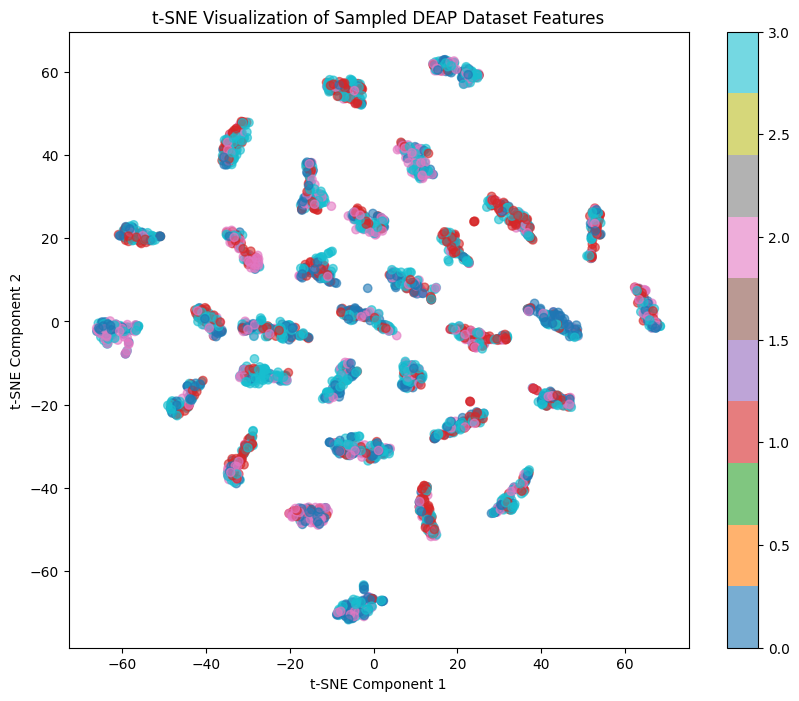

t-SNE visualization completed and saved to plots/tsne_visualization.png


In [ ]:
# Add this to a new cell
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataLoader
batch_size = 64
dataloader = DataLoader(dataset1, batch_size=batch_size, shuffle=False)

# Collect features and labels
all_features = []
all_labels = []

print("Collecting features...")
with torch.no_grad():
    for batch_data in dataloader:
        eeg_signals, labels = batch_data
        # Reshape EEG signals to 2D (batch_size, channels * time_points)
        features = eeg_signals.view(eeg_signals.size(0), -1).cpu().numpy()
        all_features.append(features)
        all_labels.append(labels.cpu().numpy())

# Concatenate all batches
X = np.concatenate(all_features, axis=0)
y = np.concatenate(all_labels, axis=0)

print("Applying t-SNE...")
# Apply t-SNE
sample_size = 3000  # Or any number small enough to process quickly
indices = np.random.choice(len(X), sample_size, replace=False)
X_sample = X[indices]
y_sample = y[indices]

print("Applying t-SNE on sampled data...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_sampled = tsne.fit_transform(X_sample)

# Visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne_sampled[:, 0], X_tsne_sampled[:, 1], c=y_sample, cmap='tab10', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE Visualization of Sampled DEAP Dataset Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.show()

print("t-SNE visualization completed and saved to plots/tsne_visualization.png")

In [10]:
data, label = dataset1[0]
print(data.shape)  # Should output: torch.Size([5, 9, 9])
print("Label:", label)


torch.Size([1, 32, 5])
Label: 3
